In [1]:
import os

%matplotlib inline
import string
import sys

import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import re
import sys
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.compose import make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectFromModel

In [2]:
test = pd.read_csv('test.csv')

train = pd.read_csv('train.csv')
train = train.drop(columns=["ID"])
train.head()

,Age,AI_Interaction_Level,Satisfaction_with_AI_Services,AI_Personalization_Effectiveness,AI_Response_Time,Overall_Usage_Frequency,Customer_Service_Interactions,Change_in_Usage_Patterns,Customer_Churn
0,59,2,7,7,2,18,5,2,1
1,49,2,6,5,1,3,2,0,0
2,35,2,3,3,3,8,2,1,1
3,63,2,3,3,2,6,6,2,1
4,28,4,6,6,1,11,3,-1,0


In [3]:
X = train.drop(columns=["Customer_Churn"])
y = train["Customer_Churn"]

X_test = test.drop(columns=["Customer_Churn"])
y_test = test["Customer_Churn"]


missingValue = X.apply(lambda x: sum(x.isna()))
print(missingValue)


Age                                 0
AI_Interaction_Level                0
Satisfaction_with_AI_Services       0
AI_Personalization_Effectiveness    0
AI_Response_Time                    0
Overall_Usage_Frequency             0
Customer_Service_Interactions       0
Change_in_Usage_Patterns            0
dtype: int64


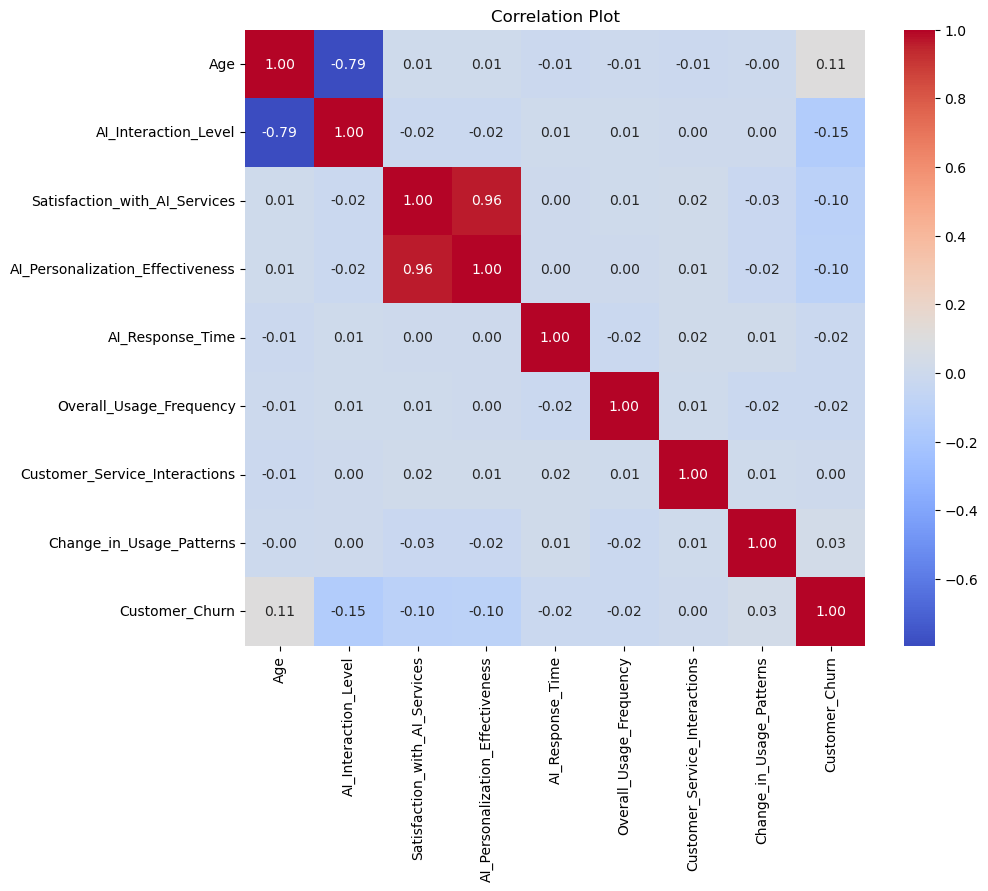

In [4]:
correlation_matrix = train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Plot')
plt.show()

Based on the interaction plot, AI_interaction:Age, AI_personnaliz:satisfaction

In [5]:
train["Customer_Churn"].value_counts()

0    2909
1    2091
Name: Customer_Churn, dtype: int64

In [6]:
rf = RandomForestClassifier(n_estimators=100, random_state=12345)
rf.fit(X, y)
feature_importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 
                                      'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
0,Age,0.211010
5,Overall_Usage_Frequency,0.209488
6,Customer_Service_Interactions,0.148456
2,Satisfaction_with_AI_Services,0.108009
3,AI_Personalization_Effectiveness,0.099773
7,Change_in_Usage_Patterns,0.091455
1,AI_Interaction_Level,0.071593
4,AI_Response_Time,0.060217


In [7]:
threshold = 0.09
important_features = feature_importance_df[feature_importance_df['Importance'] > threshold]['Feature'].tolist()
X_selected = X[important_features]


In [8]:
numeric_cols = ["Age", 
                "Satisfaction_with_AI_Services", 
                "AI_Personalization_Effectiveness",
                "Overall_Usage_Frequency",
                "Customer_Service_Interactions"]

categorical_cols = [#"AI_Interaction_Level", 
                    #"AI_Response_Time",
                    "Change_in_Usage_Patterns"]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop="if_binary", handle_unknown="ignore")

preprocessor_X = make_column_transformer(
    (numeric_transformer, numeric_cols),
    (categorical_transformer, categorical_cols),
    remainder="passthrough"
)
transformed_X_train = preprocessor_X.fit_transform(X)

poly = PolynomialFeatures(degree=2, include_bias=False)
transformed_X_train = poly.fit_transform(transformed_X_train)
transformed_X_train

array([[ 1.3084166 ,  0.52001047,  0.51119337, ...,  4.        ,
         4.        ,  4.        ],
       [ 0.51181593,  0.17086956, -0.18232633, ...,  4.        ,
         2.        ,  1.        ],
       [-0.60342501, -0.87655316, -0.87584603, ...,  4.        ,
         6.        ,  9.        ],
       ...,
       [ 0.51181593,  0.17086956,  0.16443352, ...,  9.        ,
         9.        ,  9.        ],
       [-0.12546461,  0.52001047,  0.85795322, ...,  9.        ,
         3.        ,  1.        ],
       [-0.12546461,  0.17086956,  0.51119337, ...,  4.        ,
         6.        ,  9.        ]])

In [9]:
SCORING = "accuracy"

In [10]:
pipe_rf = make_pipeline(preprocessor_X, RandomForestClassifier(random_state=12345))
rfScores = cross_validate(pipe_rf, X_selected, y, scoring=SCORING, return_train_score=True)
print("Mean validation score %0.3f" % (np.mean(rfScores["test_score"])))
print("Mean training score %0.3f" % (np.mean(rfScores["train_score"])))
pd.DataFrame(rfScores)

Mean validation score 0.583
Mean training score 1.000


,fit_time,score_time,test_score,train_score
0,0.682552,0.041028,0.577,0.99950
1,0.651102,0.039632,0.579,0.99950
2,0.635784,0.040128,0.586,0.99950
3,0.663398,0.039454,0.596,1.00000
4,0.627680,0.039357,0.576,0.99975


In [34]:
pipe_rf = make_pipeline(preprocessor_X, RandomForestClassifier(random_state=12345))

param_grid = {
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_depth': [None, 10, 20]
}

forest_search_multi = GridSearchCV(
    pipe_rf,
    param_grid,
    scoring=SCORING,
    return_train_score=True,
    n_jobs=-1,
)
forest_search_multi.fit(X, y)

print("Best hyperparameter values: ", forest_search_multi.best_params_)
print("Best score: %0.3f" % (forest_search_multi.best_score_))

Best hyperparameter values:  {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 200}
Best score: 0.604


In [33]:
pipe_rf = make_pipeline(preprocessor_X, GradientBoostingClassifier(random_state=12345))
rfScores = cross_validate(pipe_rf, X_selected, y, scoring=SCORING, return_train_score=True)
print("Mean validation score %0.3f" % (np.mean(rfScores["test_score"])))
print("Mean training score %0.3f" % (np.mean(rfScores["train_score"])))
pd.DataFrame(rfScores)

Mean validation score 0.592
Mean training score 0.669


,fit_time,score_time,test_score,train_score
0,0.427716,0.009737,0.604,0.67075
1,0.438645,0.009183,0.578,0.67175
2,0.424034,0.009338,0.618,0.66275
3,0.441151,0.008594,0.590,0.66675
4,0.400981,0.008334,0.571,0.67150


In [36]:
pipe_rf = make_pipeline(preprocessor_X, GradientBoostingClassifier(random_state=12345))

param_grid = {
    'gradientboostingclassifier__n_estimators': [100, 200, 300],
    'gradientboostingclassifier__max_depth': [None, 10, 20],
    'gradientboostingclassifier__max_features': ['auto', 'sqrt', 'log2']
}

forest_search_multi = GridSearchCV(
    pipe_rf,
    param_grid,
    scoring=SCORING,
    return_train_score=True,
    n_jobs=-1,
)
forest_search_multi.fit(X, y)

print("Best hyperparameter values: ", forest_search_multi.best_params_)
print("Best score: %0.3f" % (forest_search_multi.best_score_))

/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/sklearn/pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **f

Best hyperparameter values:  {'gradientboostingclassifier__max_depth': None, 'gradientboostingclassifier__max_features': 'sqrt', 'gradientboostingclassifier__n_estimators': 200}
Best score: 0.590


In [37]:
pipe_rf = make_pipeline(preprocessor_X, DecisionTreeClassifier(random_state=12345))
rfScores = cross_validate(pipe_rf, X_selected, y, scoring=SCORING, return_train_score=True)
print("Mean validation score %0.3f" % (np.mean(rfScores["test_score"])))
print("Mean training score %0.3f" % (np.mean(rfScores["train_score"])))
pd.DataFrame(rfScores)

Mean validation score 0.535
Mean training score 1.000


,fit_time,score_time,test_score,train_score
0,0.024296,0.005435,0.505,0.99950
1,0.023480,0.005884,0.542,0.99950
2,0.023775,0.005373,0.533,0.99950
3,0.023993,0.005307,0.550,1.00000
4,0.023246,0.005618,0.543,0.99975


In [39]:
best = make_pipeline(preprocessor_X, RandomForestClassifier(n_estimators=200))
best.fit(X, y)
pred = best.predict(X_test)
accuracy_score(y_test, pred)

0.6568

In [59]:
prediction = best.predict(X_test)
predicted_df = pd.DataFrame({'Predicted': prediction})

In [60]:
ID = test['ID']

In [62]:
result_df = pd.concat([ID, predicted_df], axis=1)
result_df.to_csv('result.csv', index=False)

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier()
}
results = pd.DataFrame(columns=["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"])

for name, model in models.items():
    model.fit(X, y)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y)
    precision = precision_score(y_test, y)
    recall = recall_score(y_test, y)
    f1 = f1_score(y_test, y)
    roc_auc = roc_auc_score(y_test, y)
    
    # Store results
    results.loc[name] = [accuracy, precision, recall, f1, roc_auc]

print("Model Performance:")
print(results)